# Project Overview

We've been tasked to find "The 5 best zipcodes for us to invest in."   This is an extremely open-ended question and we have been encouraged to take this in any reasonable direction.  For this project I am pretending I am a consultant to a REIT (Real Estate Investment Trust) that is looking to add to their portfolio of rental properties in Single Family Homes.  They have between $1.5-2 Million to invest.

The Goal of our REIT (or any investment company) is to optimize for Profit.  In our case we are looking for the greatest ROI in terms of Monthly Rental income against our costs of operations.   For sake of ease, I'll assume our only investment costs is the Home purchase (median home price).    


Project Plan:
1. Load Data
2. Preproccessing and Sanitization
3. EDA and visualizations
4. Time Series Modeling
5. Summary and Conclusions

# 1 - Load Data and Libraries

In [1]:
# importing our libraries

import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# ignoring warnings for cleaner output.
import warnings
warnings.filterwarnings('ignore')

We are loading two sets of zillow data.   
- The first one is provided to us as the "zillow_data.csv" file in the repo.  
- The second one is the Zip_MedianRentalPrice_Sfr.csv" file I downloaded from the zillow housing data site at (https://www.zillow.com/research/data/)

In [2]:
# we were provided a csv file to work with so let's load it up and see whats there.
df = pd.read_csv("zillow_data.csv")

In [3]:
print(len(df))

14723


In [4]:
# We needed rental information to make our investment decisions, so we're using Zillow's median rental price data as well.

rental_prices = pd.read_csv("zillow/Zip_MedianRentalPrice_Sfr.csv")

In [5]:
print (len(rental_prices))
rental_prices.head(3)

2678


,RegionName,City,State,Metro,CountyName,SizeRank,2010-02,2010-03,2010-04,2010-05,...,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12
0,10025,New York,NY,New York-Newark-Jersey City,New York County,1,NaN,NaN,NaN,NaN,...,3500.0,3525.0,3525.0,3550.0,3500.0,3405.0,3500.0,3500.0,3500.0,3500.0
1,10023,New York,NY,New York-Newark-Jersey City,New York County,2,NaN,NaN,NaN,NaN,...,3000.0,3000.0,3250.0,3090.0,3080.0,3180.0,3300.0,3297.5,3300.0,3150.0
2,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,3,NaN,NaN,NaN,NaN,...,2150.0,2100.0,2150.0,2100.0,2100.0,2100.0,2150.0,2162.5,2200.0,2200.0


Ok, there's a lot to work with here (14k zip codes)

- data seems to have 7 columns of identifying information and the remainder (264) seem to be median prices by date (April 1996 - April 2018, which is 22 yrs).  That's the equivalent of 264 months, so it checks out.

Other columns that are interesting to me are Region ID, Region Name and SizeRank.   Lets figure out what those are.
 - I'm not sure what Region ID is just yet, so we'll play with that later.
 - Region name seems to accurately reflect zip code.   as 60657 is the Lincoln Park neighborhood in Chicago, and 98109 is South Lake Union neighborhood in Seattle and 55124 is Apple Valley, MN.  All are places I used to call home.
- SizeRank is a bit tricky to define.  I've searched around a bit and found references to population size, but that doesn't completely line up, but the top 10 by size rank are definitely all heavily populated zipcodes.  I have a theory that it is ranking of quantity of inventory over a period of time, but alas, I have no way to verify this. 



# 2 - Preprocessing and Sanitization

Before we start processing the data, lets talk about what we're looking for within the data.
As a profit-focused REIT, we are seeking for the largest ROI markets we can find.   



In this section we will:
- Explore data
- Determine process to adjudicate NaN and other bad data points
- Create a merged dataframe to calculate ROI and determine our top20 zipcodes to explore.

Notes on processing our Top20 zipcodes for analysis: 
To calculate Annual ROI in this project we are defining it as:

Annual ROI = (12 * Monthly Rental Income) / Median Home Price

There are many different ways to skin this cat as we have a time series of rental prices but largely we care about Today's rental prices, so we will use April 2018's price as "today" for both our rental and home prices.  Note: we can get as in depth about this as we want (median trailing 12/24/36 months adjusted for seasonality, etc), but realistically we are just looking for a starting point to further explore our data.

In [6]:
# what is RegionID?   I still don't know, and frankly our analysis doesn't care if we do.  Lets just ignore it.
df.RegionID.describe()

count     14723.000000
mean      81075.010052
std       31934.118525
min       58196.000000
25%       67174.500000
50%       78007.000000
75%       90920.500000
max      753844.000000
Name: RegionID, dtype: float64

In [7]:
# I lived in Seattle in zip  of 98109.  Bingo, it comes up as Seattle.  
# Note: I'm sure no one ever has confused RegionID and RegionName.  I did for the models later and in an effort
# to save anyone else some time.  PLEASE!! note that RegionName is Zipcode.   

df[df["RegionName"] == 98109]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
963,99569,98109,Seattle,WA,Seattle,King,964,249000.0,251000.0,253000.0,...,1103700,1115400,1129800,1145500,1163000,1181900,1198600,1210700,1221300,1227900


Repeat after me.  RegionName = Zip Code

In [8]:
# lets look at some of our pregroupings of data.

df.City.value_counts().head()

New York       114
Los Angeles     95
Houston         88
San Antonio     48
Washington      45
Name: City, dtype: int64

In [9]:
# Metro quantity > City quanity.  Good to know, since we use that later as well.
df.Metro.value_counts().head()

New York                          779
Los Angeles-Long Beach-Anaheim    347
Chicago                           325
Philadelphia                      281
Washington                        249
Name: Metro, dtype: int64

In [10]:
# lets do a quick NA check to see how much additional sanitization we have to do.
df.isna().sum().head()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
dtype: int64

In [11]:
# inspecting the NaNs
df_nan = df[df['1996-04'].isnull()]

In [12]:
df_nan.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
20,61625,10011,New York,NY,New York,New York,21,NaN,NaN,NaN,...,12137600,12112600,12036600,12050100,12016300,11946500,11978100,11849300,11563000,11478300
36,61796,10456,New York,NY,New York,Bronx,37,NaN,NaN,NaN,...,357900,357100,356500,357200,362000,368500,374100,379800,388100,394400
105,84613,60611,Chicago,IL,Chicago,Cook,106,NaN,NaN,NaN,...,1475200,1473900,1469500,1472100,1477800,1486000,1497300,1508600,1508100,1493200
156,62048,11238,New York,NY,New York,Kings,157,NaN,NaN,NaN,...,2673300,2696700,2716500,2724000,2744300,2768900,2810700,2848100,2869600,2885300
232,69533,27834,Greenville,NC,Greenville,Pitt,233,NaN,NaN,NaN,...,100100,98700,97400,96100,95900,96300,97000,98300,100200,101200


In [13]:
# taking a look at df's with NaNs in earlier years
# first zip that shows up is 10011 in NYC
zipcode = 10011
df_test = df.loc[df['RegionName'] == zipcode]

There are a few things to note after exploring our NaN values
- Metro Areas may not be important for us here so they have been left alone for the time being.
- the time series NaNs all seem to occur prior at older dates as it seems Zillow did not collect data at that time.   

Since, we are being asked to pare down our zipcodes into a managable portion, chances are good we would eliminate rows that do contain NaN values, so initially, we are choosing to ignore all the NaNs, until a need to address them arises.


In [14]:
# Let's see how many zipcodes overlap between the two datasets.

unique_zips = set(df.RegionName).intersection(set(rental_prices.RegionName))
len(unique_zips)

2465

We have 2465 zipcodes with both median home prices and average single family home rental prices.  That's plenty to work with.

However, we should note that our time periods are not aligned.   While our rental prices are up to date to 2019, our home prices are available up to april of 2018.   We will be using that April 2018 date as the stopping point of our time series.


In [15]:
market = df[df['RegionName'].isin(list(unique_zips))]

In [16]:
market["today_price"] = market["2018-04"]
market.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,today_price
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,310000,312500,314100,315000,316600,318100,319600,321100,321800,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,320600,320200,320400,320800,321200,321200,323000,326900,329900,329900
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119400,120000,120300,120300,120300,120300,120500,121000,121500,121500
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,158700,160200,161900,162800,162800,162800,162900,163500,164300,164300
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,167400,168400,169600,170900,172300,173300,174200,175400,176200,176200


In [17]:
print(market.shape)

(2465, 273)


In [18]:
market.drop(market.iloc[:, 7:272], inplace=True, axis=1)
market.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,today_price
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,321800
2,91982,77494,Katy,TX,Houston,Harris,3,329900
4,93144,79936,El Paso,TX,El Paso,El Paso,5,121500
5,91733,77084,Houston,TX,Houston,Harris,6,164300
8,91940,77449,Katy,TX,Houston,Harris,9,176200


In [19]:
# finally we can merge our two datasets.

merged_df = market.merge(rental_prices[["RegionName", "2018-04"]], how = 'inner', on = ['RegionName'])

In [20]:
# Now we can calculate ROI.  Please check our presentation to how we arrived at using this calculation, but in reality 
# we are using a comparable metric since we are not condsidering any other revenue or costs in this calcuation.

# this ROI calculation is (Average Monthly Rental Price * 12 months) / price of property

# there are many ways to think about this.   Most importantly, this is the percentage of the house we would
# get in rental income each year.  Interesting perspective is a 15 or 30 year fixed mortgage pays back the
# house in 15-30 years respectively.  Our 15% ROI is paying the house back in roughly 7 yeaars.

merged_df["ROI"] = ( merged_df["2018-04"] * 12) / merged_df["today_price"] 

In [21]:
# let's take a look at our top 20 markets by ROI
# We arbitrarily chose the top 3000 markets by size (They are scored inversely with SizeRank 1 being the largest)
# so we could avoid situations where there was low inventory and high rental prices (basically all 
# beach properties in Suffolk County, NY).

merged_df[merged_df["SizeRank"] < 3000].sort_values(by=["ROI"], ascending = False).head(20)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,today_price,2018-04,ROI
630,84466,60411,Chicago Heights,IL,Chicago,Cook,883,77700,1300.0,0.200772
1427,61129,8618,Trenton,NJ,Trenton,Mercer,2418,81100,1325.0,0.196054
226,66825,21215,Baltimore,MD,Baltimore,Baltimore City,317,75000,1200.0,0.192000
1186,84464,60409,Calumet City,IL,Chicago,Cook,1865,82500,1300.0,0.189091
1100,74663,38127,Memphis,TN,Memphis,Shelby,1691,42700,650.0,0.182670
1206,81298,53218,Milwaukee,WI,Milwaukee,Milwaukee,1917,69000,1050.0,0.182609
1589,85642,62703,Springfield,IL,Springfield,Sangamon,2795,55600,800.0,0.172662
862,65367,18102,Allentown,PA,Allentown,Lehigh,1280,73300,1050.0,0.171896
16,92515,78572,Mission,TX,McAllen,Hidalgo,27,103900,1412.5,0.163138
897,60390,6606,Bridgeport,CT,Stamford,Fairfield,1332,184300,2500.0,0.162778


Our top 20 list includes a bunch of zipcodes all with estimated 15% or better ROI.  This is very promising.  Lets save a list of those zipcodes for us to use later in our time series analysis.


In [22]:
Top20_Zips = merged_df[merged_df["SizeRank"] < 3000].sort_values(by=["ROI"], ascending = False).head(20)["RegionName"].tolist()

In [23]:
# Great. We now have a list of 20 zip codes with great ROIs for us to analyze later.  
# However, if we think about this like business men, it wouldn't make sense  to invest in markets too spread out.
# Instead, we probably want to have a few metro areas with the largest ROI, and then focus on the top zipcodes in
# those markets.   

print(Top20_Zips)

[60411, 8618, 21215, 60409, 38127, 53218, 62703, 18102, 78572, 6606, 21229, 19131, 38111, 21218, 32304, 72204, 44121, 19124, 34113, 35810]


In [24]:
# lets take a look at the which metro areas have the most ROI's > 10%.

metro_df = merged_df[(merged_df["ROI"] > 0.10) & (merged_df["SizeRank"] < 3000)].copy()
metro_df.sort_values(by=["ROI"], ascending = False)

metro_df["Metro"].value_counts().head(10)

Houston              20
Atlanta              11
Memphis               9
Dallas-Fort Worth     9
Baltimore             9
Chicago               9
Philadelphia          8
Detroit               8
Fayetteville          5
San Antonio           5
Name: Metro, dtype: int64

In [25]:
# Let aggregate a little more information about our top metro areas, because ... I was curious.

metro_list = ["Houston", "Atlanta", "Chicago", "Memphis", "Dallas-Fort Worth", "Baltimore", "Detroit", "Philadelphia", "Miami-Fort Lauderdale", "San Antonio"]
for i in metro_list:
    print (i, ": ", round(metro_df[(metro_df["Metro"] == i)].today_price.mean()), "std: ", 
           round(metro_df[(metro_df["Metro"] == i)].today_price.std()))

Houston :  170625 std:  19068
Atlanta :  135682 std:  15826
Chicago :  132378 std:  37711
Memphis :  96411 std:  36269
Dallas-Fort Worth :  157944 std:  27804
Baltimore :  135633 std:  39346
Detroit :  105312 std:  24864
Philadelphia :  118925 std:  23700
Miami-Fort Lauderdale :  203940 std:  43284
San Antonio :  131600 std:  20897


Cool, this gives us a ton of information about the range of prices we should be expecting to pay per property

# 3 - EDA and Visualizations

In this section we're going to do a quick test on 1 zip code to make sure we're getting the results we want before looping through our list of 20 zipcodes. Here are the processes we want to test.

- melting our time series from wide format to long format
- plot time series of prices for a zipcode to show growth
- determine impact of seasonality



In [26]:
# code provided by flatiron, i didn't touch it.

font = {'family' : 'Tahoma',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

# Helper Functions needed for our loops


With an undertaking this large its clear we will need to resuse quite a bit of code.   In an effort to make code easier to read / find, I'll sacrifice chronological order and organized all my helper functions here. 

For each zipcode in our list we want to do the following:
- melt zipcode data into usable time series  (melt_zip())
- evaluate optimal pdq and PDQS configuration  (evalute_models())
- plot optimal model forecast v observed (plot_optimals()) 
- display plots (display_models())
- plot predictions (display_predictions())

We already have our melt_zip() function from earlier, so we'll create the other two functions in this section and run everything  in 4.2

In [27]:
# We need a function to change our time data from wide format to long format

# Since we will need to do this for each zip code, we tested it individually and then put it into this helper function.

def melt_zip(df_single_zipcode):
    
    """
    Summary: returns the datetimes of arg1 in long format.
    
    Parameters: arg1 (df): dataframe representing a single zipcode in wide format
    
    Returns: dataframe:  dataframe representing a single zipcode in long format
    """
    
    melted = pd.melt(df_single_zipcode, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value']).groupby('time').aggregate({'value':'mean'})
    return (melted)

In [28]:
def evaluate_models(dataset):
    
    """
    Summary: Iterate through all pdq and PDQS combinations for a particular zipcode in given dataset
             and return the best performing combination.
    
    Parameters: arg1 (df): time series dataset
    
    Returns: Series:  (p,d,q), (P,D,Q, S) - the optimal combination of these variables.
    """
    
    dataset = dataset.astype('float32')
    best_score, best_pdq, best_PDQS = float("inf"), None, None
    for pdq_combs in pdq:
        for PDQS_combs in PDQS:
            test_model = sm.tsa.statespace.SARIMAX(dataset.value, 
                                      order = pdq_combs,
                                      seasonal_order = PDQS_combs,
                                      enforce_stationarity  = False)

            test_output = test_model.fit()                
            test_prediction = test_output.get_prediction(start = start_time, dynamic = False)
            test_confidence = test_prediction.conf_int()
            test_forecasted = test_prediction.predicted_mean['2016':]
            test_actual = dataset['2016':].value

            test_RMSE = np.sqrt(mean_squared_error(test_forecasted, test_actual))
                
            if test_RMSE  < best_score:
                best_score, best_pdq, best_PDQS  =  test_RMSE, pdq_combs, PDQS_combs

    #print('Best pdq: %s PQDS: %s RMSE: %.2f' % (best_pdq, best_PDQS,  best_score))
    return (best_pdq, best_PDQS)

In [29]:
# print our models

def display_models(dataset, pdq, PDQS, zipcode):
    
    """
    Summary: composes and calculates the model given the dataset passed into the function.  We call 
             a seperate function to plot this and our predicted data.
    
    Parameters: dataset: Timeseries data
                pdq: Optimal pdq combination, Series as (p,d,q)
                PDSQ: Optimal PDQS combination, Series as (P,D,Q,S)
                zipcode: Zipcode being plotted.  Int
    
    Returns: None
    """
    
    dataset = dataset.astype('float32')

    # run model and  get diagnostic data.
    test_model = sm.tsa.statespace.SARIMAX(dataset.value, 
                                      order = pdq,
                                      seasonal_order = PDQS,
                                      enforce_stationarity  = False)
    test_output = test_model.fit()   
    start_time = pd.to_datetime('2008-01-01')
    test_prediction = test_output.get_prediction(start = start_time, dynamic = False)
    test_confidence = test_prediction.conf_int()
    
    test_forecasted = test_prediction.predicted_mean['2016':]
    test_actual = dataset['2016':].value

    # predict out 5 years
    future_prediction = test_output.get_forecast(steps = 60)
    future_ci = future_prediction.conf_int() 
    
    test_RMSE = np.sqrt(mean_squared_error(test_forecasted, test_actual))

    plot_prediction(dataset, future_prediction, future_ci, zipcode)
    


In [30]:
# run our forecast for each of our zipcodes too.  We'll reuse the code from  earlier to make our function

"""
    Summary: Calculates our forecast out 5 years and plots both observed and predicted values.
    
    Parameters: dataset: Timeseries data
                future prediction: Timeseries
                future confidence: Confidence interval for our future predictions
                zipcode: Zipcode being plotted.
    
    Returns: None
"""


def plot_prediction(dataset, future_prediction, future_confidence, zipcode):

    ax = dataset['2006':].value.plot(label = 'Observed Values', figsize =  (16,9))

    future_prediction.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(future_confidence.index,
                future_confidence.iloc[:, 0],
                future_confidence.iloc[:, 1], color='b', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Home Prices')
    ax.set_title( 'Forecasted vs Observed prices for {}.'.format(zipcode))

    plt.legend()
    plt.show()

    return None

In [31]:

# Testing our melt_zipper.  
# first 3 output should be 334200.0, 335400.0, 336500.0

zipcode = 60657
melt_test = melt_zip(df.loc[df['RegionName'] == zipcode])
melt_test.head(3)

,value
time,
1996-04-01,334200.0
1996-05-01,335400.0
1996-06-01,336500.0


<Figure size 432x288 with 0 Axes>

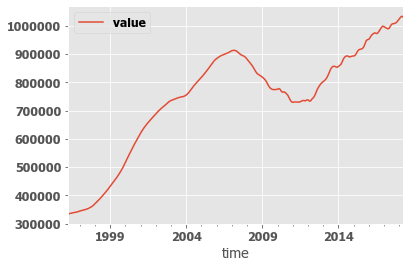

In [32]:
# And then plot it for a sanity  check

plt.figure()
melt_test.plot()
plt.legend()
plt.show()

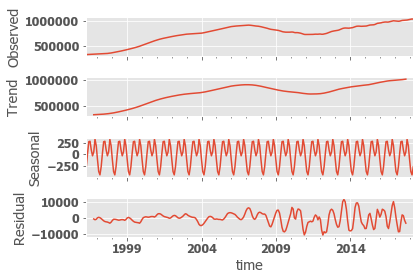

In [33]:
# lets check for seasonality so we can properly decide on model usage.

decomp_test = seasonal_decompose(melt_test.value)
decomp_test.plot()
plt.show()

Looks like our data is very seasonal so we'll need to use a seasonal model for our time series.

In [34]:
# Houston had  a lot of zipcodes with high ROI,  Lets put them in a list so we can iterate through them later.

houston_df = metro_df[(metro_df["Metro"] == "Houston")].copy()
houston_zipcodes = list(houston_df.RegionName)


In this section we created our helper functions and explored our data more fully.  
Our time series is very seasonal in nature 
And we filtered down to a final list of 20 zipcodes to explore in the Houston Metro area. 

# 4 - Modeling

Our earlier EDA showed that our time series data does have seasonality so we will need to incorporate a SARIMA(X) model for our time series forecasts.

In this section we will take the following steps:
- run a static test model for a single zip code to ensure our code works.
- iterate through all our pdq and PDQS combinations needed for the SARIMAX model at the zipcode level.
- for each zipcode, apply our optimal combination and create our models.
- put us in position to recommend our top 5 zipcodes to the client.




In [35]:
# using our "melt_test" from earlier which was zipcode = 60657

# we will arbitrary used pdq of(0,1,1) for both order and seasonal order in this test run.

test_model = sm.tsa.statespace.SARIMAX(melt_test.value, 
                                      order = (0,1,1),
                                      seasonal_order = (0,1,1,12),
                                      enforce_stationarity  = False)

test_output = test_model.fit()


In [36]:
# lets look  at the summary statistics

test_output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2212.483
Date:                            Mon, 17 Feb 2020   AIC                           4430.966
Time:                                    21:34:21   BIC                           4441.383
Sample:                                04-01-1996   HQIC                          4435.164
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8330      0.040     20.930      0.000       0.755       0.911
ma.S.L12       0.0746      0.060      1.234      0.217      -0.044       0.193
sigma2      8.638e+06   1.57e-09   5.49e+15      0.000    8.64e+06    8.64e+06
===================================================================================
Ljung-Box (Q):                      233.28   Jarque-Bera (JB):                 8.48
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               5.62   Skew:                             0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.49e+31. Standard errors may be unstable.
"""

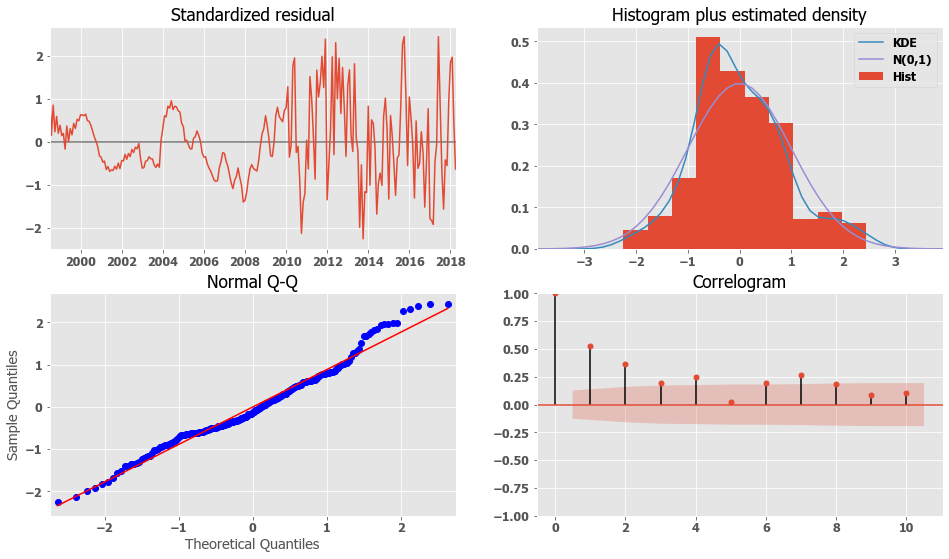

In [37]:
# lets take a peek at our diagnostic plots and make sure things are in order there.

test_output.plot_diagnostics(figsize = (16,9))
plt.show()

In [38]:
# And now our predictions.   lets use an arbitrary, but nicely round 10 years of data
start_time = pd.to_datetime('2008-01-01')

test_prediction = test_output.get_prediction(start = start_time, dynamic = False)
test_confidence = test_prediction.conf_int()

In [39]:
test_confidence.head()

,lower value,upper value
2008-01-01,879928.894658,891449.886355
2008-02-01,873569.938981,885090.930678
2008-03-01,867078.373274,878599.364971
2008-04-01,861157.746585,872678.738282
2008-05-01,854778.572271,866299.563968


lets compare our actual april 2018 values to our predicted.   

In [40]:
df.loc[df['RegionName'] == zipcode]['2018-04']

0    1030600
Name: 2018-04, dtype: int64

In [41]:
round(test_prediction.predicted_mean["2018-04-01"])

1032438.0

In [42]:
# Let's check the RMSE on our predictions from last 3 years  

test_forecasted = test_prediction.predicted_mean['2016':]
test_actual = melt_test['2016':].value

test_RMSE = np.sqrt(mean_squared_error(test_forecasted, test_actual))
print('RMSE: $',  round(test_RMSE, 2))

RMSE: $ 3354.06


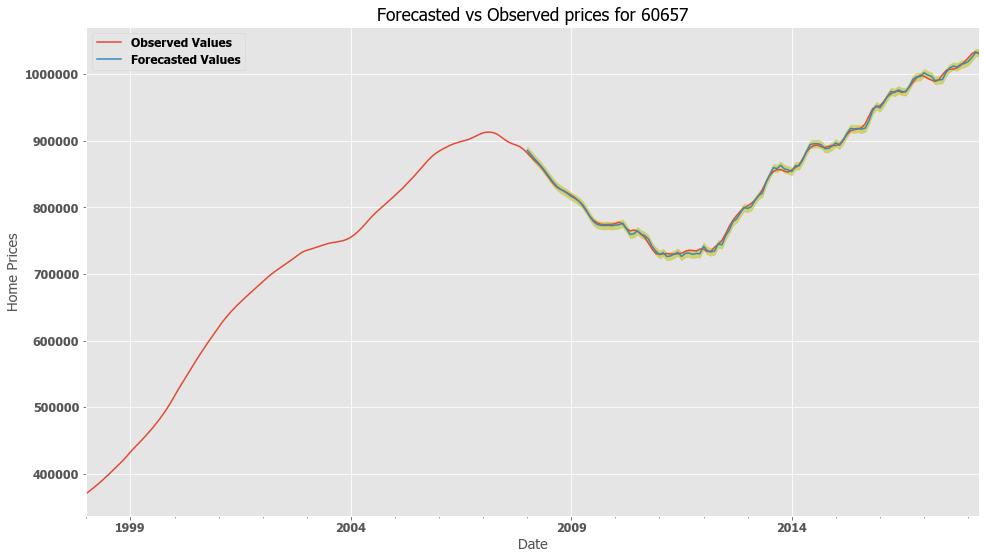

In [43]:
# Great.  let's put it all together and plot it out

rcParams['figure.figsize'] = 16, 9


ax = melt_test['1998':].value.plot(label='Observed Values')
test_prediction.predicted_mean.plot(ax=ax, label='Forecasted Values')

# confidence
ax.fill_between(test_confidence.index,
                test_confidence.iloc[:, 0],
                test_confidence.iloc[:, 1], color='y', alpha=.5)

ax.set_xlabel('Date')
ax.set_ylabel('Home Prices')
ax.set_title('Forecasted vs Observed prices for 60657')
plt.legend()

plt.show()

ok, our predictions look pretty good.  Lets plug this back in and run all iterations using a grid search we learned about from Dr. Jason Brownlee (https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/)

# 4.1 - Optimal combinations

In [44]:
# define our ranges of our pdq values\

p_values = d_values = q_values = range(0,2)
pdq = list(itertools.product(p_values, d_values, q_values))
PDQS = [(x[0], x[1], x[2], 12) for x in pdq]


In [45]:
# adding a timer to see how long my coffee break can be when I test this.
import timeit

In [46]:
# again we are doing a test run of our function for our melt_tested zipcode of 60657.

start = timeit.default_timer()
evaluate_models(melt_test)
stop = timeit.default_timer()

print('Time: ', stop- start)

Time:  18.9076141


Great, so now we have a function to use after we have a time series established for each zip code. And we know we can run 3 of these a minute, meaning I can step away for 7 minutes every time I run the Houston dataset.


In [47]:
# recall from earlier.
print (houston_zipcodes)
houston_df.head()

[77084, 77449, 77521, 77083, 77070, 77375, 77373, 77396, 77040, 77089, 77088, 77539, 77099, 77090, 77388, 77064, 77338, 77471, 77074, 77073]


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,today_price,2018-04,ROI
3,91733,77084,Houston,TX,Houston,Harris,6,164300,1500.0,0.109556
4,91940,77449,Katy,TX,Houston,Harris,9,176200,1475.0,0.100454
291,92003,77521,Baytown,TX,Houston,Harris,404,171600,1495.0,0.104545
292,91732,77083,Mission Bend,TX,Houston,Fort Bend,406,164500,1500.0,0.109422
378,91719,77070,Houston,TX,Houston,Harris,530,197900,1650.0,0.100051


In [48]:
# Find the Optimal combinations

# remember,   Houston: - houston_zipcodes = list of zipcodes, houston_df = dataframe of houston data. 
start = timeit.default_timer()

optimal_combinations = []
# For loop - all zipcodes we care about.
for zipcode in houston_zipcodes:
    melted_zip = melt_zip(df.loc[df['RegionName'] == zipcode])

    #in each zipcode, we want the optimal combination returned.  (run evaluate_models)
    
    optimal_combinations.append((zipcode, evaluate_models(melted_zip)))
 
    
    # save combinations for zip code.  optimal_list = {zipcode, (pdq order), (PDQS order)}
print(optimal_combinations)    

stop = timeit.default_timer()

print('Time: ', stop- start)

[(77084, ((1, 1, 1), (0, 0, 1, 12))), (77449, ((1, 1, 1), (0, 0, 1, 12))), (77521, ((1, 1, 0), (0, 0, 0, 12))), (77083, ((1, 1, 1), (1, 0, 1, 12))), (77070, ((1, 0, 1), (0, 0, 0, 12))), (77375, ((1, 1, 1), (1, 0, 1, 12))), (77373, ((1, 1, 1), (0, 0, 0, 12))), (77396, ((1, 1, 1), (0, 0, 1, 12))), (77040, ((1, 1, 1), (1, 0, 1, 12))), (77089, ((1, 1, 1), (0, 0, 1, 12))), (77088, ((1, 1, 1), (1, 0, 1, 12))), (77539, ((1, 1, 1), (1, 0, 1, 12))), (77099, ((1, 1, 1), (1, 0, 1, 12))), (77090, ((1, 1, 1), (1, 0, 1, 12))), (77388, ((1, 1, 1), (1, 0, 1, 12))), (77064, ((1, 1, 1), (1, 0, 1, 12))), (77338, ((1, 1, 1), (0, 0, 1, 12))), (77471, ((1, 1, 1), (1, 0, 1, 12))), (77074, ((1, 1, 1), (1, 0, 1, 12))), (77073, ((1, 0, 1), (0, 0, 1, 12)))]
Time:  460.3071807


ok, lets not run THAT again. For houston, if I want to rerun it, it will take 6-7 minutes to compelete.
More importantly, we have the optimal combinations for each of our zipcodes.


In [49]:
# for sake of not running that code again, lets re-extract all the values and make this much more sanitary to read.

for i in optimal_combinations:
    print (i[0], i[1][0], i[1][1])

77084 (1, 1, 1) (0, 0, 1, 12)
77449 (1, 1, 1) (0, 0, 1, 12)
77521 (1, 1, 0) (0, 0, 0, 12)
77083 (1, 1, 1) (1, 0, 1, 12)
77070 (1, 0, 1) (0, 0, 0, 12)
77375 (1, 1, 1) (1, 0, 1, 12)
77373 (1, 1, 1) (0, 0, 0, 12)
77396 (1, 1, 1) (0, 0, 1, 12)
77040 (1, 1, 1) (1, 0, 1, 12)
77089 (1, 1, 1) (0, 0, 1, 12)
77088 (1, 1, 1) (1, 0, 1, 12)
77539 (1, 1, 1) (1, 0, 1, 12)
77099 (1, 1, 1) (1, 0, 1, 12)
77090 (1, 1, 1) (1, 0, 1, 12)
77388 (1, 1, 1) (1, 0, 1, 12)
77064 (1, 1, 1) (1, 0, 1, 12)
77338 (1, 1, 1) (0, 0, 1, 12)
77471 (1, 1, 1) (1, 0, 1, 12)
77074 (1, 1, 1) (1, 0, 1, 12)
77073 (1, 0, 1) (0, 0, 1, 12)


# 4.2 Our outputs

lets take a look again at all our Houston zipcodes in their glory


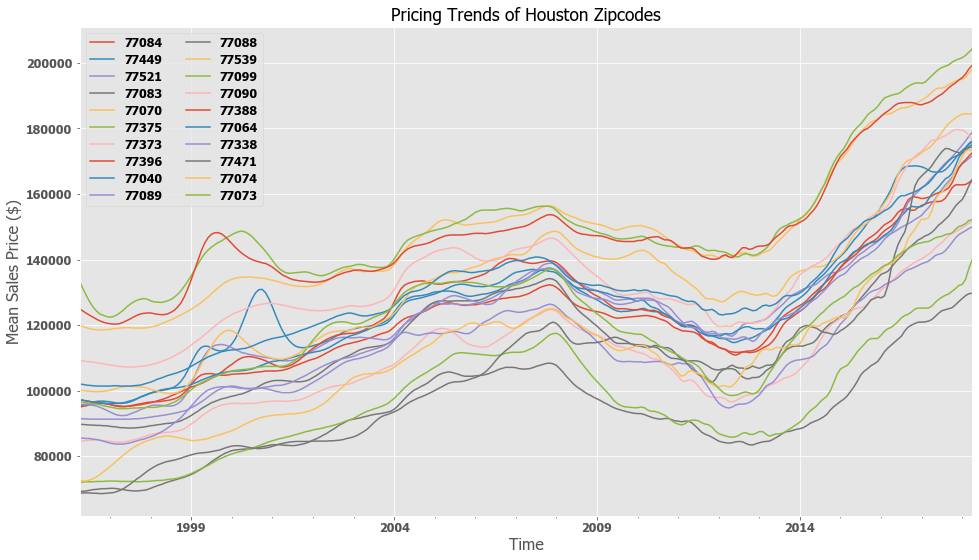

In [50]:

plt.figure(figsize= (16,9))
for zip in houston_zipcodes:
    city = melt_zip(df.loc[df['RegionName'] == zip]).value
    city.plot(label = zip)
plt.legend(ncol = 2)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Mean Sales Price ($)', fontsize=16)
plt.title('Pricing Trends of Houston Zipcodes')
plt.show()

While we still have access to all these zipcodes, lets take a closer look at this project's goal.   

We needed to interpret "What 5 zipcodes should we invest in?" in terms of delivering against our client's needs and strategic outlook.

Let's revisit those and extrapolate out further our strategy.

- Client is a smaller botique real estate investment trust with 1.5 to 2 million USD available for investment.
- Assets will be used as rental units in the client's real estate portfolio. 
- This strategy means driving profitability by maximizing the <b>difference between rental price and asset value.</b>
- As investing always has inherent risk, minimizing risk is preferred.   
- Risk in real estate is a very hard thing to quantify on individual assets, however using a diversified portfolio perspective (the more assets the merrier) is a way to reduce overall risk.   

In summary:  We are looking for a combination of best rate of return while being able to manage a larger inventory.

With Houston's sales price mostly < $200k we should be able to help guide our client in creating a diversified, double digit return portfolio.

Goal:  8-10 properties each with 10%+ ROI.


In [51]:
# first lets add our optimal configurations to our dataframe.
pdq_list = []
PDQS_list = []
for i in optimal_combinations:
    pdq_list.append(i[1][0])
    PDQS_list.append(i[1][1])


In [52]:
houston_df['pdq'] = pdq_list
houston_df['PDQS'] = PDQS_list
houston_df['idx'] = houston_df["RegionName"]

In [53]:
# our Top 10 by ROI
top_10 = houston_df.sort_values(by='ROI', ascending = False).head(10).copy()
top_10.set_index('RegionName')

,RegionID,City,State,Metro,CountyName,SizeRank,today_price,2018-04,ROI,pdq,PDQS,idx
RegionName,,,,,,,,,,,,
77088,91737,Houston,TX,Houston,Harris,1271,129700,1345.0,0.124441,"(1, 1, 1)","(1, 0, 1, 12)",77088
77040,91689,Houston,TX,Houston,Harris,1067,175900,1687.5,0.115122,"(1, 1, 1)","(1, 0, 1, 12)",77040
77073,91722,Houston,TX,Houston,Harris,2534,152200,1425.0,0.112352,"(1, 0, 1)","(0, 0, 1, 12)",77073
77338,91852,Humble,TX,Houston,Harris,1837,150000,1390.0,0.111200,"(1, 1, 1)","(0, 0, 1, 12)",77338
77396,91902,Atascocita,TX,Houston,Harris,1036,172600,1595.0,0.110892,"(1, 1, 1)","(0, 0, 1, 12)",77396
77373,91883,Spring,TX,Houston,Harris,643,151600,1400.0,0.110818,"(1, 1, 1)","(0, 0, 0, 12)",77373
77084,91733,Houston,TX,Houston,Harris,6,164300,1500.0,0.109556,"(1, 1, 1)","(0, 0, 1, 12)",77084
77083,91732,Mission Bend,TX,Houston,Fort Bend,406,164500,1500.0,0.109422,"(1, 1, 1)","(1, 0, 1, 12)",77083
77471,91961,Rosenberg,TX,Houston,Fort Bend,2003,174200,1575.0,0.108496,"(1, 1, 1)","(1, 0, 1, 12)",77471



  77088 



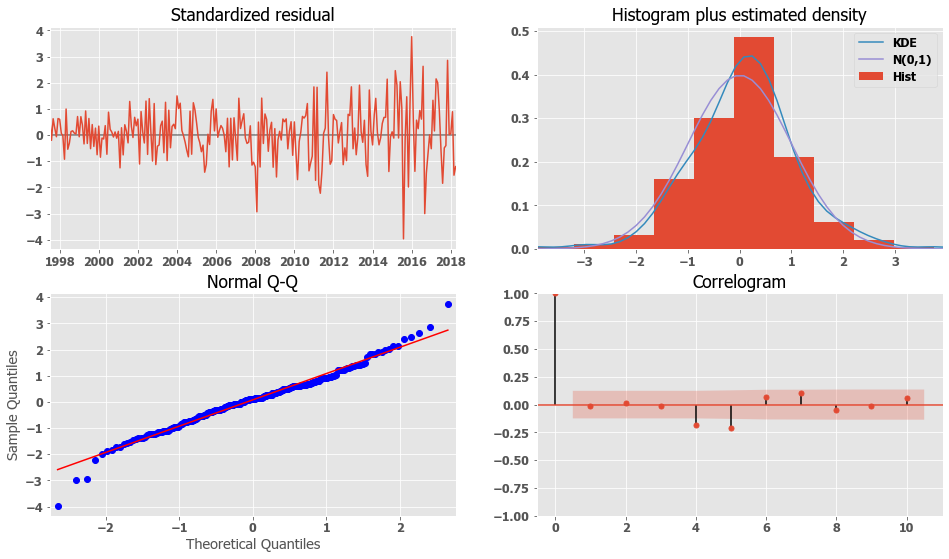


  77040 



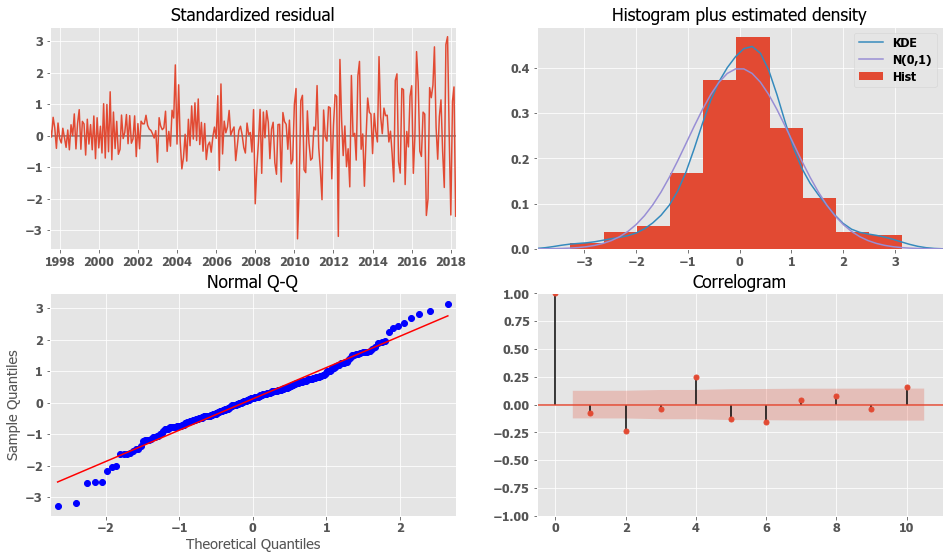


  77073 



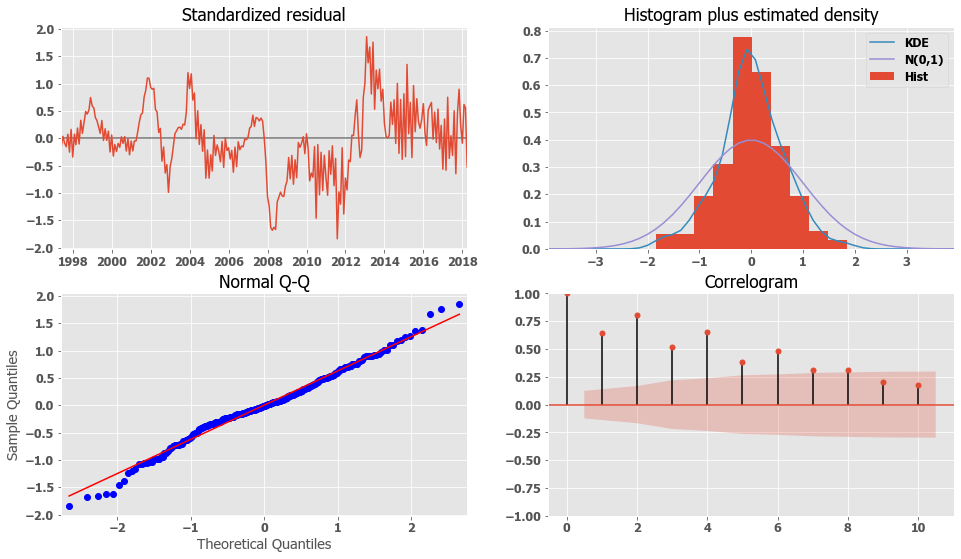


  77338 



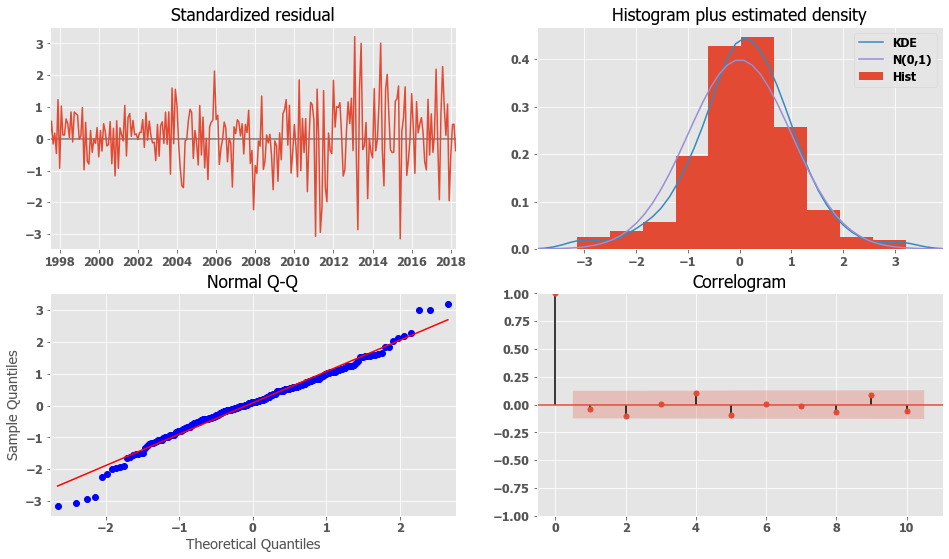


  77396 



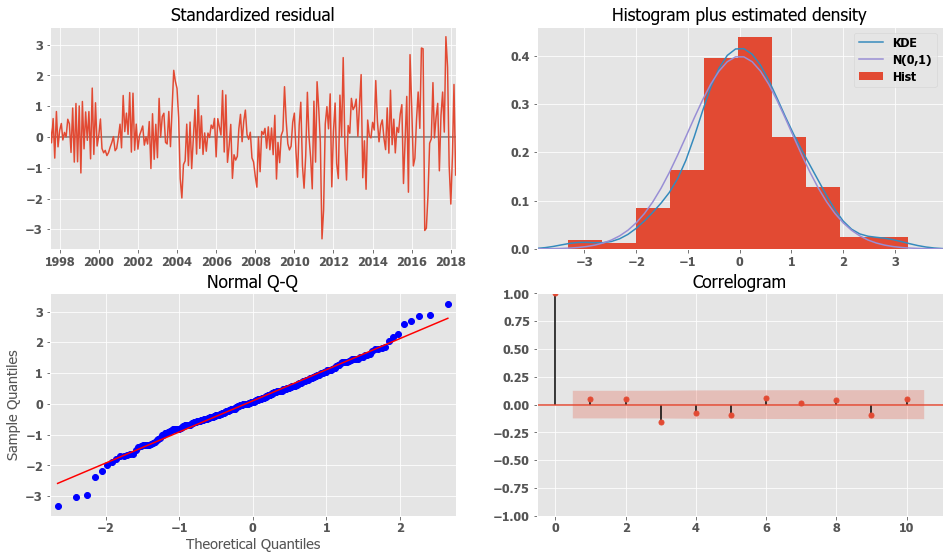


  77373 



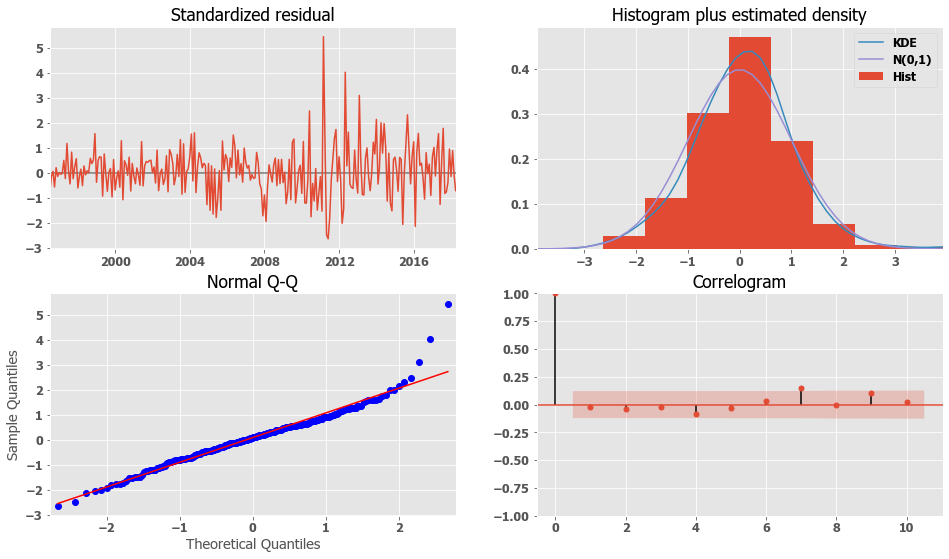


  77084 



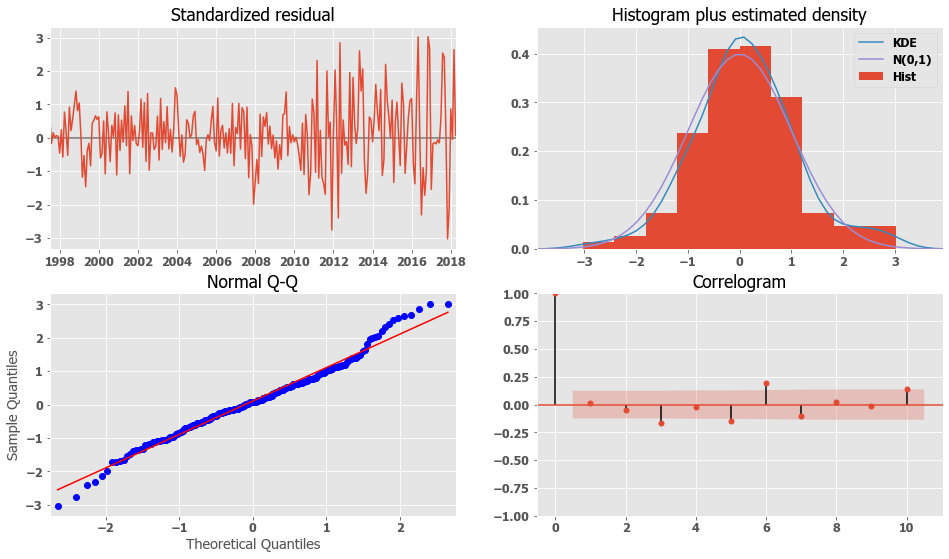


  77083 



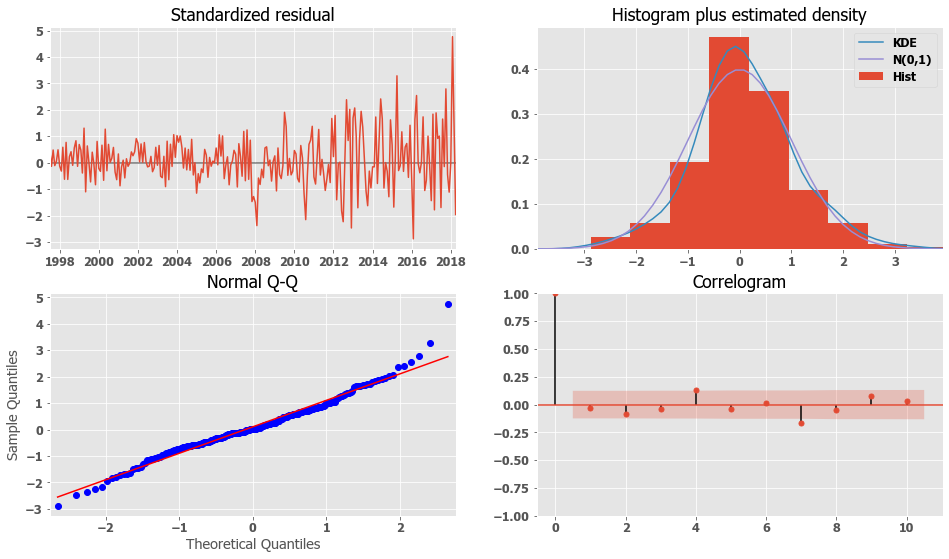


  77471 



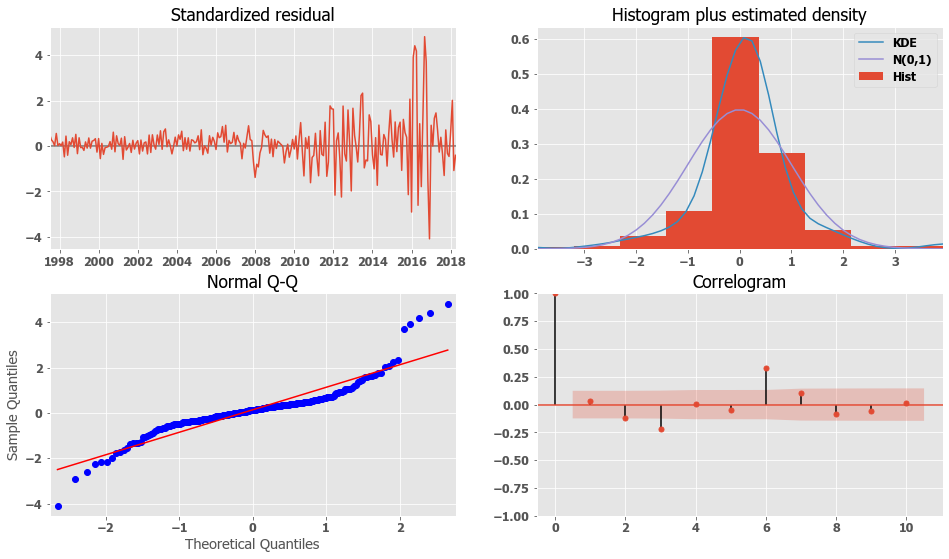


  77099 



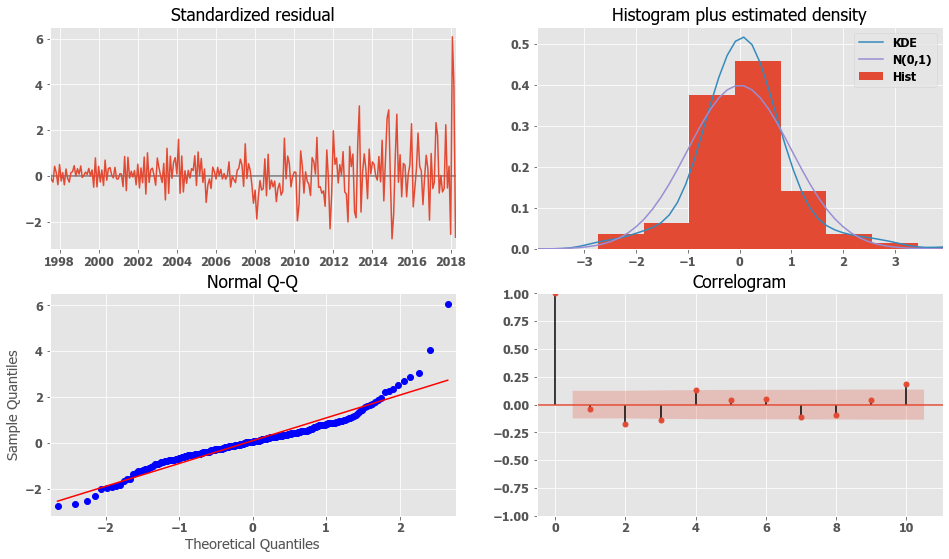

In [55]:
# Diagnostic plots for our zipcodes.

for i in range(len(top_10['RegionName'])):
    
    zipcode = top_10.iat[i, 12]
    pdq = top_10.iat[i,  10]
    PDQS = top_10.iat[i,  11]
    melted_zip = melt_zip(df.loc[df['RegionName'] == zipcode])

    test_model = sm.tsa.statespace.SARIMAX(melted_zip.value, 
                                      order = pdq,
                                      seasonal_order = PDQS,
                                      enforce_stationarity  = False,
                                      enforce_invertibility = False)

    test_output = test_model.fit()                
    test_prediction = test_output.get_prediction(start = start_time, dynamic = False)
    test_confidence = test_prediction.conf_int()
    test_forecasted = test_prediction.predicted_mean['2016':]
    test_actual = melted_zip['2016':].value

    test_RMSE = np.sqrt(mean_squared_error(test_forecasted, test_actual))
    
    #plot diagnostic
    print("\n ", zipcode, "\n")
    test_output.plot_diagnostics(figsize = (16,9))
    plt.show()

In [ ]:
# And now our models.

for i in range(len(top_10['RegionName'])):
    
    zipcode = top_10.iat[i, 12]
    pdq = top_10.iat[i,  10]
    PDQS = top_10.iat[i,  11]
    melted_zip = melt_zip(df.loc[df['RegionName'] == zipcode])   
    display_models(melted_zip, pdq, PDQS, zipcode)

# 5 - Summary

We evaluated a lot zipcodes using top level aggregate data (mean sales prices) over a time series.   Using that data, we were able to broadly compare price performance over a period of 20-25 years.    

Our goal was to identify at the zipcode level, where our client should further use resources to explore investment opportunity.

We did this by calculating a makeshift ROI by incorporating Zillow's average rental prices per zipcode and comparing the sales and rental prices at the last sales data point we have (April 2018).  We called this "ROI"

In addition to our ROI calculation, we filtered for our 3000 largest sized zipcodes (zillows SizeRank) and then reaggregated them back to their respective metro areas so we could find a particular metro area to further explore.

We ended up choosing Houston, TX because we had almost twice as many zipcodes to explore with a single team on the ground.

We used a Seasonal ARIMA mpdel to forecast our time series data, and optimized our p,q,d scores at the zipcode level.   

We finished by plotting out the diagnostics and 5-year forecasts for our 10 highest performing zipcodes (ROI) in Houston.

# Conclusion

In the end we chose our "5 Best" zipcodes for further investigation.  (after all we are not going to buy an entire zipcode, right?)

They are:
77073
77338
77396
77373
77083
